In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, GroupShuffleSplit,RandomizedSearchCV
from xgboost import XGBClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb

In [9]:
train_1 = pd.read_csv('Train.csv')
test_1 = pd.read_csv('Test.csv')
train = train_1.copy()
test = test_1.copy()

# delete = ['f23','f24','f25','f26','f27']
# for i in delete:
#     del train[i]

In [10]:
feat = train.columns.to_list()
target='grade'
feat.remove(target)

In [11]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=13,sampling_strategy='all')
X_train_ovr,y_train_ovr = sm.fit_sample(train[feat],train[target])
print(X_train_ovr.shape)

(2360, 28)


In [16]:
train_ovr = pd.DataFrame(X_train_ovr,columns=feat)
train_ovr[target] = y_train_ovr

In [44]:
def splitter(train, features, target, ts=False):
    if ts:
        trainX, validX, trainY, validY = train_test_split(train[features],
                                                          train[target], test_size=0.2,
                                                          random_state=13, shuffle=False)
    else:
        trainX, validX, trainY, validY = train_test_split(train[features],
                                                      train[target], test_size=0.2,
                                                      random_state=13)
    return trainX, validX, trainY, validY

def lgb_model(train, test, features, target, ts=False):
    evals_result = {}
    trainX, validX, trainY, validY = splitter(train, features, target, ts=ts)
    print("LGB Model")
    lgb_train_set = lgb.Dataset(trainX, label=trainY)
    lgb_valid_set = lgb.Dataset(validX, label=validY)

    MAX_ROUNDS = 2000
    lgb_params = {
#         "boosting": 'gbdt',  # "dart",
        "num_class":5,
#         "learning_rate": 0.01,
        "nthread": -1,
        "seed": 13,
        "num_boost_round": MAX_ROUNDS,
        "objective": "multiclass",
        "metric": "multi_logloss",
    }

    lgb_model = lgb.train(
        lgb_params,
        train_set=lgb_train_set,
        valid_sets=[lgb_train_set, lgb_valid_set],
        early_stopping_rounds=10,
        verbose_eval=100,
        evals_result=evals_result,
    )

    lgb.plot_importance(lgb_model, figsize=(24, 24))
    lgb.plot_metric(evals_result, metric='multi_logloss')
    
    preds = lgb_model.predict(test[feat])
    return lgb_model, preds

LGB Model
Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.00332634	valid_1's multi_logloss: 0.0152973
Early stopping, best iteration is:
[119]	training's multi_logloss: 0.00260713	valid_1's multi_logloss: 0.013909


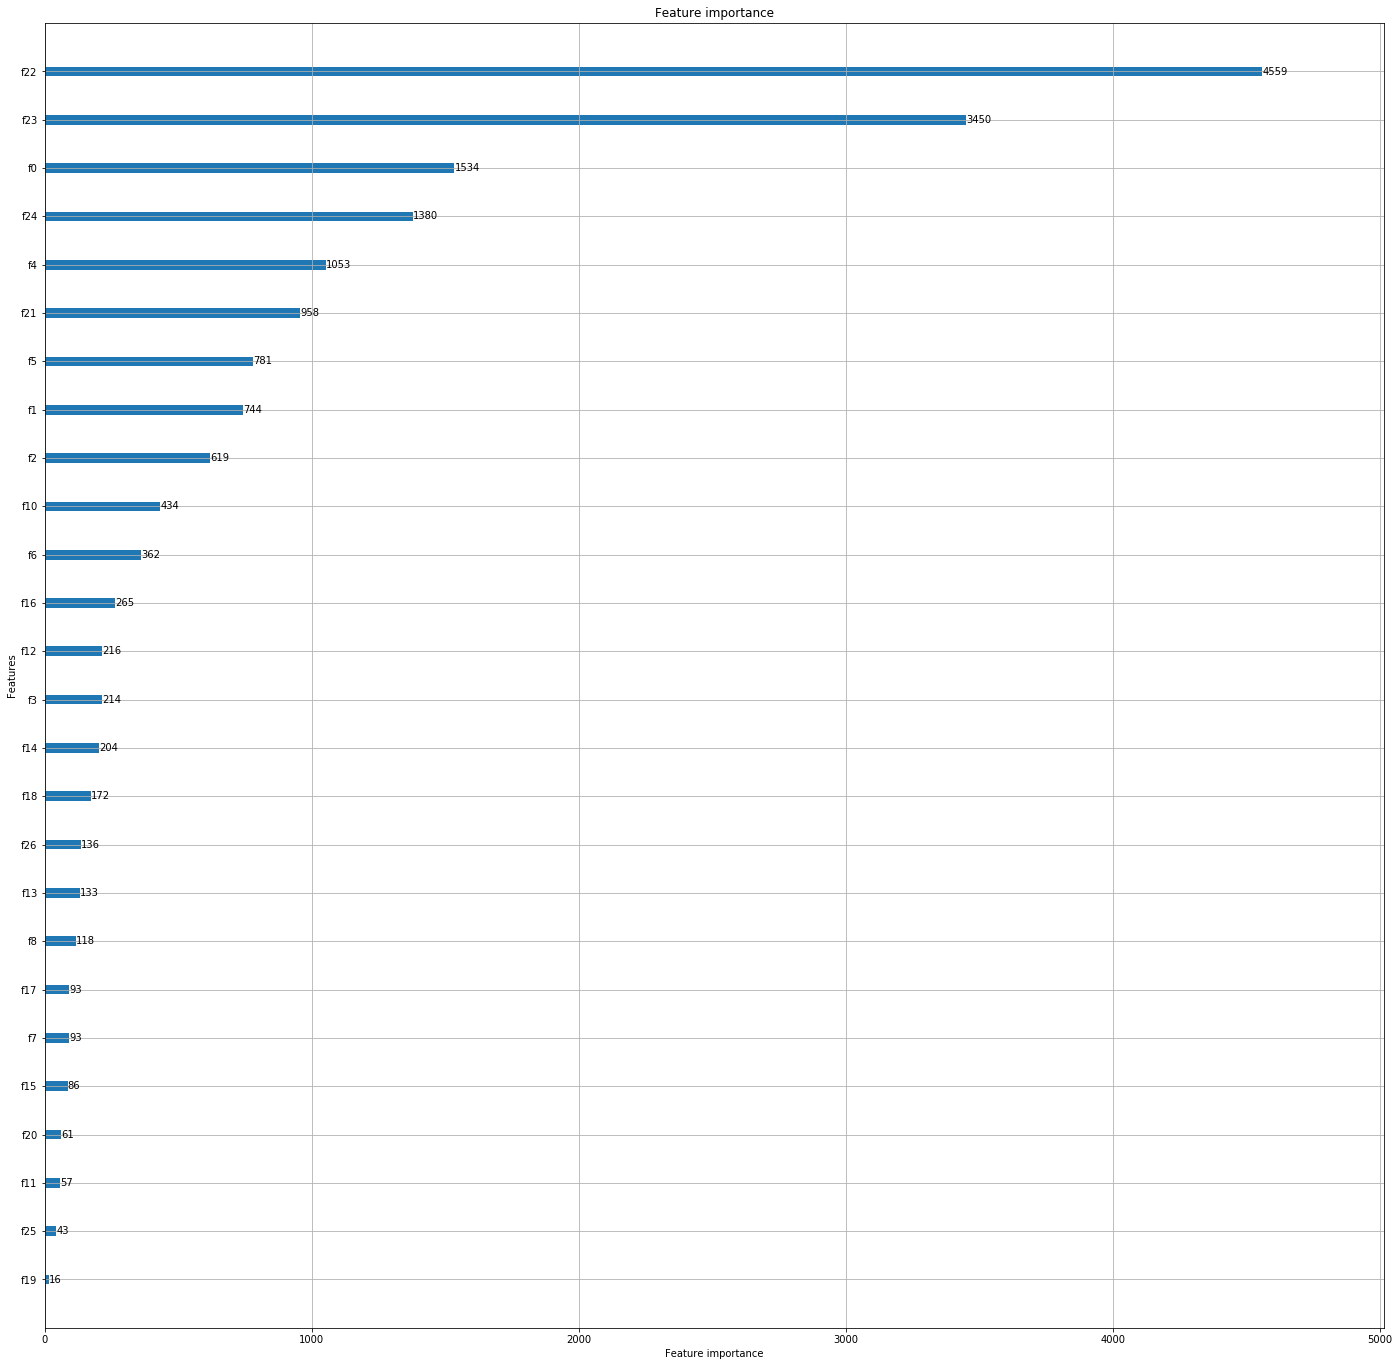

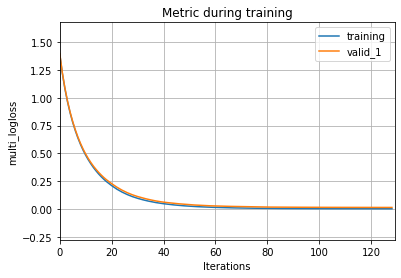

In [45]:
lgbM, lgb_preds = lgb_model(train_ovr, test, feat, target, ts=False)

In [46]:
pred = lgbM.predict(test[feat])

In [47]:
pred

array([[8.27635208e-04, 1.22732019e-04, 9.96893963e-01, 2.03706019e-03,
        1.18609972e-04],
       [4.78652605e-05, 1.33174016e-03, 1.42455548e-04, 9.98449184e-01,
        2.87551872e-05],
       [2.33025186e-01, 1.02253844e-04, 7.61124642e-01, 5.64921995e-03,
        9.86978743e-05],
       ...,
       [2.06495681e-03, 9.92552825e-01, 4.18258703e-03, 1.18307820e-03,
        1.65529808e-05],
       [1.24698057e-05, 9.53760918e-01, 4.02613480e-02, 5.85413503e-03,
        1.11129567e-04],
       [2.00345262e-05, 1.80997545e-05, 9.98558761e-01, 1.39208176e-03,
        1.10229107e-05]])

In [48]:
sub = pd.DataFrame(pred)

In [49]:
sub.to_excel("NONONONOANOTHER.xlsx",index=False)

In [50]:
sub

,0,1,2,3,4
0,0.000828,0.000123,0.996894,0.002037,0.000119
1,0.000048,0.001332,0.000142,0.998449,0.000029
2,0.233025,0.000102,0.761125,0.005649,0.000099
3,0.111868,0.000277,0.000169,0.887635,0.000050
4,0.266546,0.000117,0.727007,0.006214,0.000116
...,...,...,...,...,...
261,0.086395,0.005967,0.872598,0.034376,0.000665
262,0.000405,0.000107,0.795546,0.203867,0.000075
263,0.002065,0.992553,0.004183,0.001183,0.000017
264,0.000012,0.953761,0.040261,0.005854,0.000111
